In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"], index_col="Date")
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [4]:
df = df.resample("W").mean()

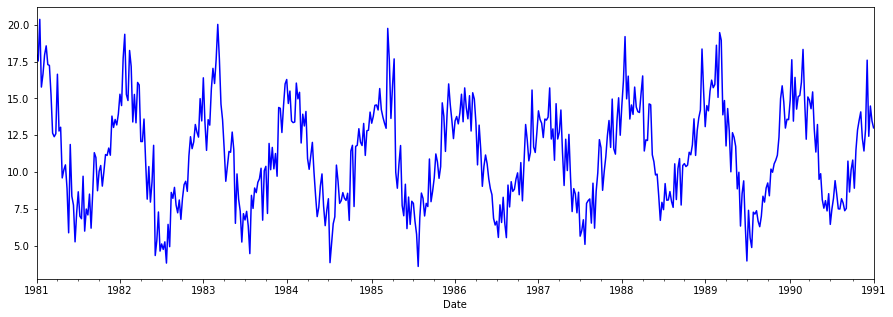

In [5]:
df.Temp.plot(figsize=(15, 5), color="b")

# Dataset Splitting

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((418, 1), (105, 1))

# Dataset & Dataloader

In [7]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [8]:
seq_len = 16
bs = 

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(8train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (26, 16, 1)
Note: last 1 data excluded

(N, S, F): (6, 16, 1)
Note: last 8 data excluded



# Arsitektur & Config

In [9]:
from jcopdl.layers import linear_block

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [11]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1, 
    "hidden_size": 64, 
    "num_layers": 2, 
    "dropout": 0,
    "seq_len": train_set.n_seq
})

# Training Preparation -> MCOC

In [12]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/lstm")

# Training

In [13]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 131.1260 | Test_cost  = 132.6189 | 




Epoch     2
Train_cost  = 124.9426 | Test_cost  = 124.6170 | 




Epoch     3
Train_cost  = 116.0091 | Test_cost  = 112.6635 | 




Epoch     4
Train_cost  = 103.4413 | Test_cost  = 98.8151 | 




Epoch     5
Train_cost  = 90.1718 | Test_cost  = 86.5035 | 




Epoch     6
Train_cost  = 78.7175 | Test_cost  = 76.1751 | 




Epoch     7
Train_cost  = 69.1225 | Test_cost  = 67.5304 | 




Epoch     8
Train_cost  = 61.1626 | Test_cost  = 60.4424 | 




Epoch     9
Train_cost  = 54.6601 | Test_cost  = 54.6029 | 




Epoch    10
Train_cost  = 49.2800 | Test_cost  = 49.6515 | 




Epoch    11
Train_cost  = 44.6875 | Test_cost  = 45.3462 | 




Epoch    12
Train_cost  = 40.6904 | Test_cost  = 41.5577 | 




Epoch    13
Train_cost  = 37.1679 | Test_cost  = 38.2026 | 




Epoch    14
Train_cost  = 34.0693 | Test_cost  = 35.2856 | 




Epoch    15
Train_cost  = 31.3894 | Test_cost  = 32.7512 | 




Epoch    16
Train_cost  = 29.0569 | Test_cost  = 30.5143 | 




Epoch    17
Train_cost  = 26.9946 | Test_cost  = 28.5087 | 




Epoch    18
Train_cost  = 25.1441 | Test_cost  = 26.6926 | 




Epoch    19
Train_cost  = 23.4763 | Test_cost  = 25.0661 | 




Epoch    20
Train_cost  = 21.9971 | Test_cost  = 23.6327 | 


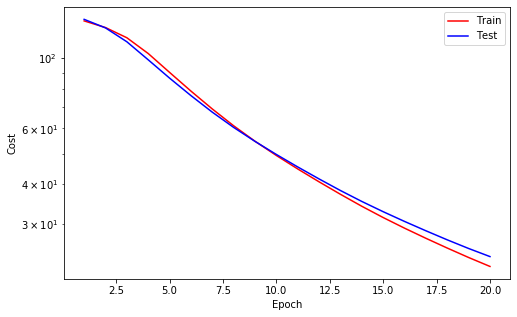



Epoch    21
Train_cost  = 20.6984 | Test_cost  = 22.3650 | 




Epoch    22
Train_cost  = 19.5560 | Test_cost  = 21.2519 | 




Epoch    23
Train_cost  = 18.5615 | Test_cost  = 20.2866 | 




Epoch    24
Train_cost  = 17.7063 | Test_cost  = 19.4602 | 




Epoch    25
Train_cost  = 16.9800 | Test_cost  = 18.7544 | 




Epoch    26
Train_cost  = 16.3609 | Test_cost  = 18.1450 | 




Epoch    27
Train_cost  = 15.8287 | Test_cost  = 17.6171 | 




Epoch    28
Train_cost  = 15.3702 | Test_cost  = 17.1599 | 




Epoch    29
Train_cost  = 14.9756 | Test_cost  = 16.7640 | 




Epoch    30
Train_cost  = 14.6359 | Test_cost  = 16.4213 | 




Epoch    31
Train_cost  = 14.3436 | Test_cost  = 16.1245 | 




Epoch    32
Train_cost  = 14.0920 | Test_cost  = 15.8675 | 




Epoch    33
Train_cost  = 13.8752 | Test_cost  = 15.6446 | 




Epoch    34
Train_cost  = 13.6882 | Test_cost  = 15.4512 | 




Epoch    35
Train_cost  = 13.5266 | Test_cost  = 15.2830 | 




Epoch    36
Train_cost  = 13.3865 | Test_cost  = 15.1364 | 




Epoch    37
Train_cost  = 13.2648 | Test_cost  = 15.0083 | 




Epoch    38
Train_cost  = 13.1585 | Test_cost  = 14.8960 | 




Epoch    39
Train_cost  = 13.0653 | Test_cost  = 14.7973 | 




Epoch    40
Train_cost  = 12.9832 | Test_cost  = 14.7102 | 


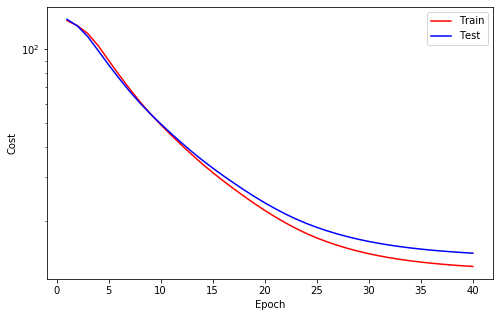



Epoch    41
Train_cost  = 12.9106 | Test_cost  = 14.6330 | 




Epoch    42
Train_cost  = 12.8459 | Test_cost  = 14.5644 | 




Epoch    43
Train_cost  = 12.7880 | Test_cost  = 14.5030 | 




Epoch    44
Train_cost  = 12.7360 | Test_cost  = 14.4480 | 




Epoch    45
Train_cost  = 12.6888 | Test_cost  = 14.3985 | 




Epoch    46
Train_cost  = 12.6459 | Test_cost  = 14.3537 | 




Epoch    47
Train_cost  = 12.6067 | Test_cost  = 14.3131 | 




Epoch    48
Train_cost  = 12.5708 | Test_cost  = 14.2761 | 




Epoch    49
Train_cost  = 12.5376 | Test_cost  = 14.2423 | 




Epoch    50
Train_cost  = 12.5069 | Test_cost  = 14.2113 | 




Epoch    51
Train_cost  = 12.4784 | Test_cost  = 14.1828 | 




Epoch    52
Train_cost  = 12.4518 | Test_cost  = 14.1565 | 




Epoch    53
Train_cost  = 12.4270 | Test_cost  = 14.1322 | 




Epoch    54
Train_cost  = 12.4038 | Test_cost  = 14.1097 | 




Epoch    55
Train_cost  = 12.3820 | Test_cost  = 14.0887 | 




Epoch    56
Train_cost  = 12.3615 | Test_cost  = 14.0692 | 




Epoch    57
Train_cost  = 12.3422 | Test_cost  = 14.0510 | 




Epoch    58
Train_cost  = 12.3240 | Test_cost  = 14.0340 | 




Epoch    59
Train_cost  = 12.3068 | Test_cost  = 14.0181 | 




Epoch    60
Train_cost  = 12.2905 | Test_cost  = 14.0031 | 


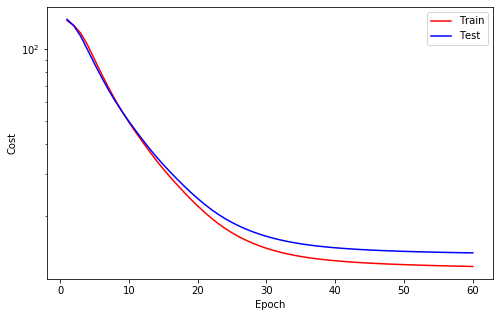



Epoch    61
Train_cost  = 12.2751 | Test_cost  = 13.9890 | 




Epoch    62
Train_cost  = 12.2605 | Test_cost  = 13.9757 | 




Epoch    63
Train_cost  = 12.2466 | Test_cost  = 13.9631 | 




Epoch    64
Train_cost  = 12.2334 | Test_cost  = 13.9513 | 




Epoch    65
Train_cost  = 12.2209 | Test_cost  = 13.9400 | 




Epoch    66
Train_cost  = 12.2089 | Test_cost  = 13.9293 | 




Epoch    67
Train_cost  = 12.1975 | Test_cost  = 13.9192 | 




Epoch    68
Train_cost  = 12.1866 | Test_cost  = 13.9096 | 




Epoch    69
Train_cost  = 12.1762 | Test_cost  = 13.9004 | 




Epoch    70
Train_cost  = 12.1662 | Test_cost  = 13.8916 | 




Epoch    71
Train_cost  = 12.1567 | Test_cost  = 13.8833 | 




Epoch    72
Train_cost  = 12.1476 | Test_cost  = 13.8753 | 




Epoch    73
Train_cost  = 12.1389 | Test_cost  = 13.8677 | 




Epoch    74
Train_cost  = 12.1305 | Test_cost  = 13.8604 | 




Epoch    75
Train_cost  = 12.1225 | Test_cost  = 13.8534 | 




Epoch    76
Train_cost  = 12.1147 | Test_cost  = 13.8467 | 




Epoch    77
Train_cost  = 12.1073 | Test_cost  = 13.8403 | 




Epoch    78
Train_cost  = 12.1002 | Test_cost  = 13.8341 | 




Epoch    79
Train_cost  = 12.0934 | Test_cost  = 13.8281 | 




Epoch    80
Train_cost  = 12.0868 | Test_cost  = 13.8224 | 


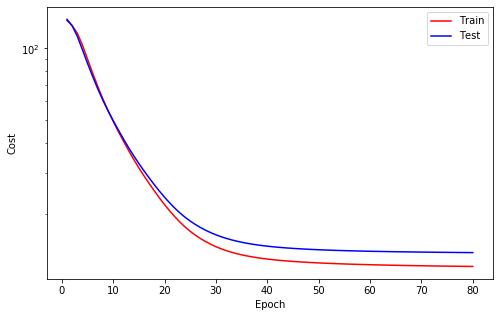



Epoch    81
Train_cost  = 12.0804 | Test_cost  = 13.8170 | 




Epoch    82
Train_cost  = 12.0743 | Test_cost  = 13.8117 | 




Epoch    83
Train_cost  = 12.0684 | Test_cost  = 13.8066 | 




Epoch    84
Train_cost  = 12.0628 | Test_cost  = 13.8017 | 




Epoch    85
Train_cost  = 12.0573 | Test_cost  = 13.7970 | 




Epoch    86
Train_cost  = 12.0520 | Test_cost  = 13.7925 | 




Epoch    87
Train_cost  = 12.0469 | Test_cost  = 13.7881 | 




Epoch    88
Train_cost  = 12.0420 | Test_cost  = 13.7839 | 




Epoch    89
Train_cost  = 12.0372 | Test_cost  = 13.7798 | 




Epoch    90
Train_cost  = 12.0326 | Test_cost  = 13.7758 | 




Epoch    91
Train_cost  = 12.0282 | Test_cost  = 13.7720 | 




Epoch    92
Train_cost  = 12.0239 | Test_cost  = 13.7684 | 




Epoch    93
Train_cost  = 12.0197 | Test_cost  = 13.7648 | 




Epoch    94
Train_cost  = 12.0157 | Test_cost  = 13.7614 | 




Epoch    95
Train_cost  = 12.0118 | Test_cost  = 13.7581 | 




Epoch    96
Train_cost  = 12.0080 | Test_cost  = 13.7548 | 




Epoch    97
Train_cost  = 12.0044 | Test_cost  = 13.7517 | 




Epoch    98
Train_cost  = 12.0008 | Test_cost  = 13.7487 | 




Epoch    99
Train_cost  = 11.9974 | Test_cost  = 13.7458 | 




Epoch   100
Train_cost  = 11.9941 | Test_cost  = 13.7430 | 


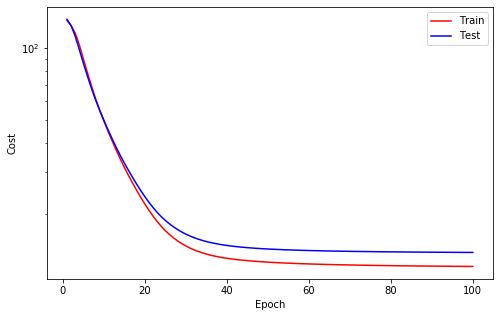



Epoch   101
Train_cost  = 11.9908 | Test_cost  = 13.7402 | 




Epoch   102
Train_cost  = 11.9877 | Test_cost  = 13.7376 | 




Epoch   103
Train_cost  = 11.9846 | Test_cost  = 13.7350 | 




Epoch   104
Train_cost  = 11.9817 | Test_cost  = 13.7325 | 




Epoch   105
Train_cost  = 11.9788 | Test_cost  = 13.7300 | 




Epoch   106
Train_cost  = 11.9760 | Test_cost  = 13.7277 | 




Epoch   107
Train_cost  = 11.9733 | Test_cost  = 13.7254 | 




Epoch   108
Train_cost  = 11.9707 | Test_cost  = 13.7232 | 




Epoch   109
Train_cost  = 11.9681 | Test_cost  = 13.7210 | 




Epoch   110
Train_cost  = 11.9656 | Test_cost  = 13.7189 | 




Epoch   111
Train_cost  = 11.9632 | Test_cost  = 13.7169 | 




Epoch   112
Train_cost  = 11.9608 | Test_cost  = 13.7149 | 




Epoch   113
Train_cost  = 11.9585 | Test_cost  = 13.7130 | 




Epoch   114
Train_cost  = 11.9563 | Test_cost  = 13.7111 | 




Epoch   115
Train_cost  = 11.9541 | Test_cost  = 13.7093 | 




Epoch   116
Train_cost  = 11.9520 | Test_cost  = 13.7075 | 




Epoch   117
Train_cost  = 11.9499 | Test_cost  = 13.7058 | 




Epoch   118
Train_cost  = 11.9479 | Test_cost  = 13.7041 | 




Epoch   119
Train_cost  = 11.9459 | Test_cost  = 13.7024 | 




Epoch   120
Train_cost  = 11.9440 | Test_cost  = 13.7008 | 


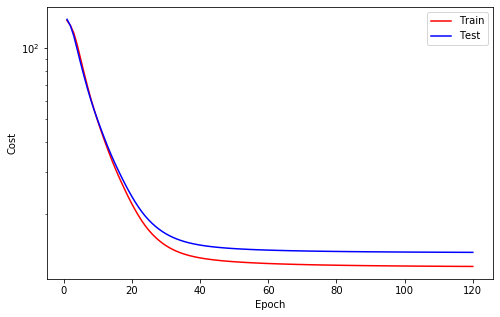



Epoch   121
Train_cost  = 11.9421 | Test_cost  = 13.6993 | 




Epoch   122
Train_cost  = 11.9403 | Test_cost  = 13.6978 | 




Epoch   123
Train_cost  = 11.9385 | Test_cost  = 13.6963 | 




Epoch   124
Train_cost  = 11.9368 | Test_cost  = 13.6948 | 




Epoch   125
Train_cost  = 11.9351 | Test_cost  = 13.6934 | 




Epoch   126
Train_cost  = 11.9334 | Test_cost  = 13.6921 | 




Epoch   127
Train_cost  = 11.9318 | Test_cost  = 13.6907 | 




Epoch   128
Train_cost  = 11.9302 | Test_cost  = 13.6894 | 




Epoch   129
Train_cost  = 11.9287 | Test_cost  = 13.6882 | 




Epoch   130
Train_cost  = 11.9272 | Test_cost  = 13.6869 | 




Epoch   131
Train_cost  = 11.9257 | Test_cost  = 13.6857 | 




Epoch   132
Train_cost  = 11.9243 | Test_cost  = 13.6845 | 




Epoch   133
Train_cost  = 11.9229 | Test_cost  = 13.6834 | 




Epoch   134
Train_cost  = 11.9215 | Test_cost  = 13.6822 | 




Epoch   135
Train_cost  = 11.9201 | Test_cost  = 13.6811 | 




Epoch   136
Train_cost  = 11.9188 | Test_cost  = 13.6800 | 




Epoch   137
Train_cost  = 11.9175 | Test_cost  = 13.6790 | 




Epoch   138
Train_cost  = 11.9163 | Test_cost  = 13.6780 | 




Epoch   139
Train_cost  = 11.9150 | Test_cost  = 13.6769 | 




Epoch   140
Train_cost  = 11.9138 | Test_cost  = 13.6760 | 


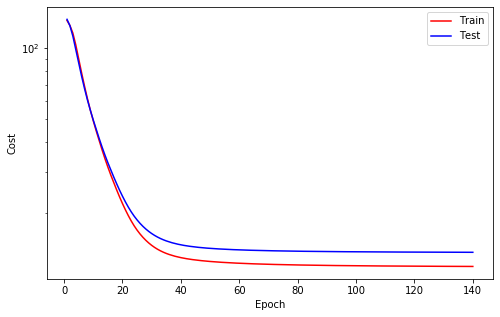



Epoch   141
Train_cost  = 11.9126 | Test_cost  = 13.6750 | 




Epoch   142
Train_cost  = 11.9115 | Test_cost  = 13.6741 | 




Epoch   143
Train_cost  = 11.9103 | Test_cost  = 13.6731 | 




Epoch   144
Train_cost  = 11.9092 | Test_cost  = 13.6722 | 




Epoch   145
Train_cost  = 11.9081 | Test_cost  = 13.6713 | 




Epoch   146
Train_cost  = 11.9070 | Test_cost  = 13.6705 | 




Epoch   147
Train_cost  = 11.9060 | Test_cost  = 13.6696 | 




Epoch   148
Train_cost  = 11.9049 | Test_cost  = 13.6688 | 




Epoch   149
Train_cost  = 11.9039 | Test_cost  = 13.6680 | 




Epoch   150
Train_cost  = 11.9029 | Test_cost  = 13.6672 | 




Epoch   151
Train_cost  = 11.9019 | Test_cost  = 13.6664 | 




Epoch   152
Train_cost  = 11.9009 | Test_cost  = 13.6656 | 




Epoch   153
Train_cost  = 11.9000 | Test_cost  = 13.6648 | 




Epoch   154
Train_cost  = 11.8989 | Test_cost  = 13.6638 | 




Epoch   155
Train_cost  = 11.8971 | Test_cost  = 13.6618 | 




Epoch   156
Train_cost  = 11.8943 | Test_cost  = 13.6622 | 
==> EarlyStop patience =  1 | Best test_cost: 13.6618




Epoch   157
Train_cost  = 11.8927 | Test_cost  = 13.6627 | 
==> EarlyStop patience =  2 | Best test_cost: 13.6618




Epoch   158
Train_cost  = 11.8919 | Test_cost  = 13.6618 | 
==> EarlyStop patience =  3 | Best test_cost: 13.6618




Epoch   159
Train_cost  = 11.8907 | Test_cost  = 13.6601 | 




Epoch   160
Train_cost  = 11.8892 | Test_cost  = 13.6578 | 


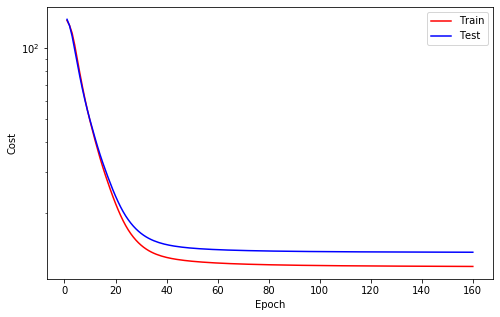



Epoch   161
Train_cost  = 11.8875 | Test_cost  = 13.6552 | 




Epoch   162
Train_cost  = 11.8856 | Test_cost  = 13.6523 | 




Epoch   163
Train_cost  = 11.8836 | Test_cost  = 13.6492 | 




Epoch   164
Train_cost  = 11.8814 | Test_cost  = 13.6460 | 




Epoch   165
Train_cost  = 11.8791 | Test_cost  = 13.6429 | 




Epoch   166
Train_cost  = 11.8770 | Test_cost  = 13.6406 | 




Epoch   167
Train_cost  = 11.8754 | Test_cost  = 13.6393 | 




Epoch   168
Train_cost  = 11.8742 | Test_cost  = 13.6387 | 




Epoch   169
Train_cost  = 11.8732 | Test_cost  = 13.6385 | 




Epoch   170
Train_cost  = 11.8724 | Test_cost  = 13.6383 | 




Epoch   171
Train_cost  = 11.8716 | Test_cost  = 13.6378 | 




Epoch   172
Train_cost  = 11.8706 | Test_cost  = 13.6369 | 




Epoch   173
Train_cost  = 11.8694 | Test_cost  = 13.6359 | 




Epoch   174
Train_cost  = 11.8681 | Test_cost  = 13.6349 | 




Epoch   175
Train_cost  = 11.8667 | Test_cost  = 13.6339 | 




Epoch   176
Train_cost  = 11.8649 | Test_cost  = 13.6327 | 




Epoch   177
Train_cost  = 11.8628 | Test_cost  = 13.6317 | 




Epoch   178
Train_cost  = 11.8606 | Test_cost  = 13.6310 | 




Epoch   179
Train_cost  = 11.8587 | Test_cost  = 13.6299 | 




Epoch   180
Train_cost  = 11.8570 | Test_cost  = 13.6283 | 


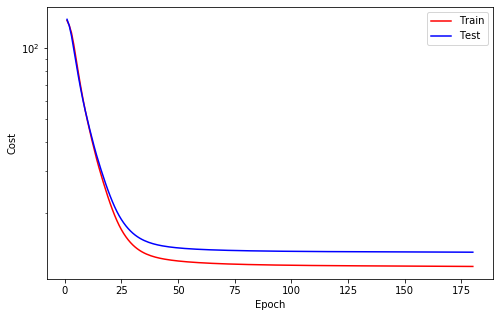



Epoch   181
Train_cost  = 11.8553 | Test_cost  = 13.6261 | 




Epoch   182
Train_cost  = 11.8535 | Test_cost  = 13.6236 | 




Epoch   183
Train_cost  = 11.8516 | Test_cost  = 13.6210 | 




Epoch   184
Train_cost  = 11.8496 | Test_cost  = 13.6182 | 




Epoch   185
Train_cost  = 11.8475 | Test_cost  = 13.6153 | 




Epoch   186
Train_cost  = 11.8452 | Test_cost  = 13.6123 | 




Epoch   187
Train_cost  = 11.8422 | Test_cost  = 13.6091 | 




Epoch   188
Train_cost  = 11.8384 | Test_cost  = 13.6064 | 




Epoch   189
Train_cost  = 11.8346 | Test_cost  = 13.6042 | 




Epoch   190
Train_cost  = 11.8313 | Test_cost  = 13.6011 | 




Epoch   191
Train_cost  = 11.8276 | Test_cost  = 13.5972 | 




Epoch   192
Train_cost  = 11.8235 | Test_cost  = 13.5934 | 




Epoch   193
Train_cost  = 11.8199 | Test_cost  = 13.5899 | 




Epoch   194
Train_cost  = 11.8167 | Test_cost  = 13.5860 | 




Epoch   195
Train_cost  = 11.8136 | Test_cost  = 13.5814 | 




Epoch   196
Train_cost  = 11.8102 | Test_cost  = 13.5763 | 




Epoch   197
Train_cost  = 11.8064 | Test_cost  = 13.5707 | 




Epoch   198
Train_cost  = 11.8021 | Test_cost  = 13.5643 | 




Epoch   199
Train_cost  = 11.7966 | Test_cost  = 13.5573 | 




Epoch   200
Train_cost  = 11.7895 | Test_cost  = 13.5520 | 


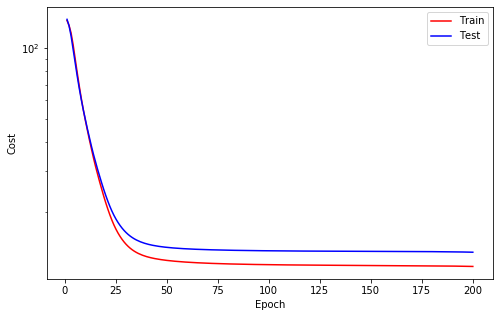



Epoch   201
Train_cost  = 11.7826 | Test_cost  = 13.5457 | 




Epoch   202
Train_cost  = 11.7747 | Test_cost  = 13.5394 | 




Epoch   203
Train_cost  = 11.7673 | Test_cost  = 13.5356 | 




Epoch   204
Train_cost  = 11.7620 | Test_cost  = 13.5300 | 




Epoch   205
Train_cost  = 11.7556 | Test_cost  = 13.5200 | 




Epoch   206
Train_cost  = 11.7457 | Test_cost  = 13.5084 | 




Epoch   207
Train_cost  = 11.7357 | Test_cost  = 13.4992 | 




Epoch   208
Train_cost  = 11.7280 | Test_cost  = 13.4878 | 




Epoch   209
Train_cost  = 11.7195 | Test_cost  = 13.4736 | 




Epoch   210
Train_cost  = 11.7095 | Test_cost  = 13.4583 | 




Epoch   211
Train_cost  = 11.6985 | Test_cost  = 13.4435 | 




Epoch   212
Train_cost  = 11.6861 | Test_cost  = 13.4303 | 




Epoch   213
Train_cost  = 11.6721 | Test_cost  = 13.4191 | 




Epoch   214
Train_cost  = 11.6568 | Test_cost  = 13.4044 | 




Epoch   215
Train_cost  = 11.6379 | Test_cost  = 13.3918 | 




Epoch   216
Train_cost  = 11.6215 | Test_cost  = 13.3806 | 




Epoch   217
Train_cost  = 11.6070 | Test_cost  = 13.3648 | 




Epoch   218
Train_cost  = 11.5912 | Test_cost  = 13.3409 | 




Epoch   219
Train_cost  = 11.5719 | Test_cost  = 13.3088 | 




Epoch   220
Train_cost  = 11.5491 | Test_cost  = 13.2730 | 


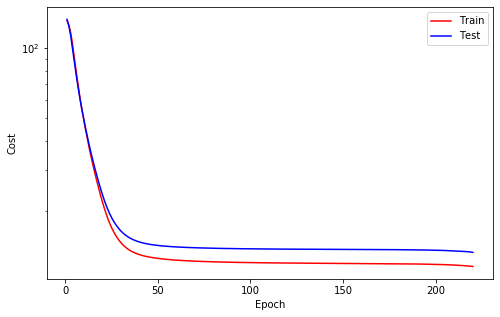



Epoch   221
Train_cost  = 11.5255 | Test_cost  = 13.2396 | 




Epoch   222
Train_cost  = 11.5028 | Test_cost  = 13.2087 | 




Epoch   223
Train_cost  = 11.4787 | Test_cost  = 13.1839 | 




Epoch   224
Train_cost  = 11.4580 | Test_cost  = 13.1653 | 




Epoch   225
Train_cost  = 11.4404 | Test_cost  = 13.1423 | 




Epoch   226
Train_cost  = 11.4194 | Test_cost  = 13.1145 | 




Epoch   227
Train_cost  = 11.3956 | Test_cost  = 13.0856 | 




Epoch   228
Train_cost  = 11.3718 | Test_cost  = 13.0530 | 




Epoch   229
Train_cost  = 11.3447 | Test_cost  = 13.0113 | 




Epoch   230
Train_cost  = 11.3125 | Test_cost  = 12.9665 | 




Epoch   231
Train_cost  = 11.2772 | Test_cost  = 12.9185 | 




Epoch   232
Train_cost  = 11.2312 | Test_cost  = 12.8802 | 




Epoch   233
Train_cost  = 11.1934 | Test_cost  = 12.8389 | 




Epoch   234
Train_cost  = 11.1549 | Test_cost  = 12.7976 | 




Epoch   235
Train_cost  = 11.1157 | Test_cost  = 12.7397 | 




Epoch   236
Train_cost  = 11.0716 | Test_cost  = 12.6821 | 




Epoch   237
Train_cost  = 11.0285 | Test_cost  = 12.6327 | 




Epoch   238
Train_cost  = 10.9853 | Test_cost  = 12.5790 | 




Epoch   239
Train_cost  = 10.9317 | Test_cost  = 12.5170 | 




Epoch   240
Train_cost  = 10.8683 | Test_cost  = 12.4565 | 


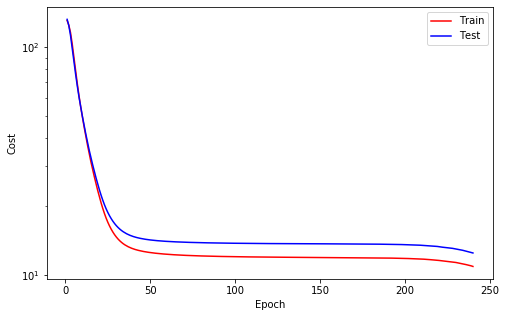



Epoch   241
Train_cost  = 10.8060 | Test_cost  = 12.3822 | 




Epoch   242
Train_cost  = 10.7301 | Test_cost  = 12.2805 | 




Epoch   243
Train_cost  = 10.6388 | Test_cost  = 12.1703 | 




Epoch   244
Train_cost  = 10.5387 | Test_cost  = 12.0587 | 




Epoch   245
Train_cost  = 10.4456 | Test_cost  = 11.9360 | 




Epoch   246
Train_cost  = 10.3478 | Test_cost  = 11.8165 | 




Epoch   247
Train_cost  = 10.2508 | Test_cost  = 11.6892 | 




Epoch   248
Train_cost  = 10.1512 | Test_cost  = 11.5667 | 




Epoch   249
Train_cost  = 10.0545 | Test_cost  = 11.4464 | 




Epoch   250
Train_cost  = 9.9539 | Test_cost  = 11.3282 | 




Epoch   251
Train_cost  = 9.8592 | Test_cost  = 11.2124 | 




Epoch   252
Train_cost  = 9.7652 | Test_cost  = 11.1063 | 




Epoch   253
Train_cost  = 9.6796 | Test_cost  = 11.0027 | 




Epoch   254
Train_cost  = 9.5987 | Test_cost  = 10.8910 | 




Epoch   255
Train_cost  = 9.5184 | Test_cost  = 10.7946 | 




Epoch   256
Train_cost  = 9.4463 | Test_cost  = 10.7080 | 




Epoch   257
Train_cost  = 9.3721 | Test_cost  = 10.6169 | 




Epoch   258
Train_cost  = 9.2986 | Test_cost  = 10.5461 | 




Epoch   259
Train_cost  = 9.2338 | Test_cost  = 10.4745 | 




Epoch   260
Train_cost  = 9.1699 | Test_cost  = 10.3920 | 


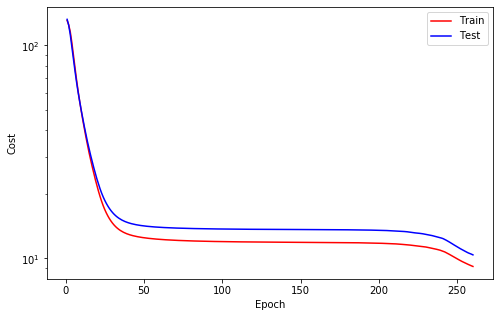



Epoch   261
Train_cost  = 9.0982 | Test_cost  = 10.3075 | 




Epoch   262
Train_cost  = 9.0246 | Test_cost  = 10.2178 | 




Epoch   263
Train_cost  = 8.9497 | Test_cost  = 10.1146 | 




Epoch   264
Train_cost  = 8.8590 | Test_cost  = 9.9981 | 




Epoch   265
Train_cost  = 8.7564 | Test_cost  = 9.8605 | 




Epoch   266
Train_cost  = 8.6196 | Test_cost  = 9.6491 | 




Epoch   267
Train_cost  = 8.4259 | Test_cost  = 9.4561 | 




Epoch   268
Train_cost  = 8.2667 | Test_cost  = 9.2302 | 




Epoch   269
Train_cost  = 8.0142 | Test_cost  = 8.9456 | 




Epoch   270
Train_cost  = 7.8223 | Test_cost  = 8.7428 | 




Epoch   271
Train_cost  = 7.6749 | Test_cost  = 8.5765 | 




Epoch   272
Train_cost  = 7.5238 | Test_cost  = 8.3240 | 




Epoch   273
Train_cost  = 7.3441 | Test_cost  = 7.9283 | 




Epoch   274
Train_cost  = 7.0372 | Test_cost  = 7.6427 | 




Epoch   275
Train_cost  = 6.8124 | Test_cost  = 7.4142 | 




Epoch   276
Train_cost  = 6.6617 | Test_cost  = 7.1865 | 




Epoch   277
Train_cost  = 6.4758 | Test_cost  = 6.9629 | 




Epoch   278
Train_cost  = 6.3405 | Test_cost  = 6.8098 | 




Epoch   279
Train_cost  = 6.2167 | Test_cost  = 6.6374 | 




Epoch   280
Train_cost  = 6.0929 | Test_cost  = 6.4511 | 


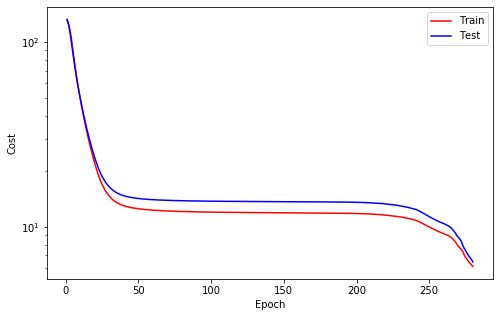



Epoch   281
Train_cost  = 5.9651 | Test_cost  = 6.2784 | 




Epoch   282
Train_cost  = 5.8574 | Test_cost  = 6.1142 | 




Epoch   283
Train_cost  = 5.7354 | Test_cost  = 5.9554 | 




Epoch   284
Train_cost  = 5.6298 | Test_cost  = 5.8078 | 




Epoch   285
Train_cost  = 5.5154 | Test_cost  = 5.6780 | 




Epoch   286
Train_cost  = 5.4198 | Test_cost  = 5.5198 | 




Epoch   287
Train_cost  = 5.2880 | Test_cost  = 5.3366 | 




Epoch   288
Train_cost  = 5.1523 | Test_cost  = 5.1549 | 




Epoch   289
Train_cost  = 5.0176 | Test_cost  = 4.9905 | 




Epoch   290
Train_cost  = 4.9008 | Test_cost  = 4.8282 | 




Epoch   291
Train_cost  = 4.7763 | Test_cost  = 4.6912 | 




Epoch   292
Train_cost  = 4.6601 | Test_cost  = 4.5738 | 




Epoch   293
Train_cost  = 4.5521 | Test_cost  = 4.4577 | 




Epoch   294
Train_cost  = 4.4566 | Test_cost  = 4.3765 | 




Epoch   295
Train_cost  = 4.3701 | Test_cost  = 4.2998 | 




Epoch   296
Train_cost  = 4.2947 | Test_cost  = 4.2253 | 




Epoch   297
Train_cost  = 4.2262 | Test_cost  = 4.1684 | 




Epoch   298
Train_cost  = 4.1642 | Test_cost  = 4.1035 | 




Epoch   299
Train_cost  = 4.1128 | Test_cost  = 4.0585 | 




Epoch   300
Train_cost  = 4.0677 | Test_cost  = 4.0066 | 


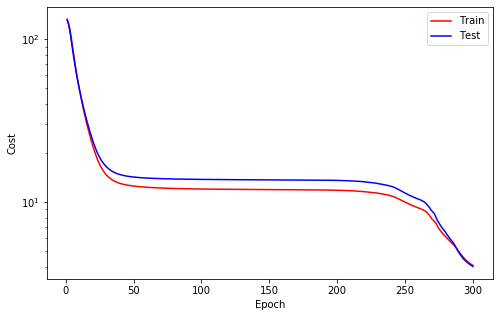



Epoch   301
Train_cost  = 4.0274 | Test_cost  = 3.9652 | 




Epoch   302
Train_cost  = 3.9901 | Test_cost  = 3.9165 | 




Epoch   303
Train_cost  = 3.9559 | Test_cost  = 3.8910 | 




Epoch   304
Train_cost  = 3.9256 | Test_cost  = 3.8245 | 




Epoch   305
Train_cost  = 3.8964 | Test_cost  = 3.8206 | 




Epoch   306
Train_cost  = 3.8711 | Test_cost  = 3.7654 | 




Epoch   307
Train_cost  = 3.8463 | Test_cost  = 3.7278 | 




Epoch   308
Train_cost  = 3.8223 | Test_cost  = 3.7189 | 




Epoch   309
Train_cost  = 3.8003 | Test_cost  = 3.6888 | 




Epoch   310
Train_cost  = 3.7796 | Test_cost  = 3.5537 | 




Epoch   311
Train_cost  = 3.7653 | Test_cost  = 3.6797 | 
==> EarlyStop patience =  1 | Best test_cost: 3.5537




Epoch   312
Train_cost  = 3.7455 | Test_cost  = 3.5215 | 




Epoch   313
Train_cost  = 3.7207 | Test_cost  = 3.5097 | 




Epoch   314
Train_cost  = 3.7271 | Test_cost  = 3.6507 | 
==> EarlyStop patience =  1 | Best test_cost: 3.5097




Epoch   315
Train_cost  = 3.7104 | Test_cost  = 3.4921 | 




Epoch   316
Train_cost  = 3.6850 | Test_cost  = 3.4006 | 




Epoch   317
Train_cost  = 3.6606 | Test_cost  = 3.5263 | 
==> EarlyStop patience =  1 | Best test_cost: 3.4006




Epoch   318
Train_cost  = 3.6634 | Test_cost  = 3.3860 | 




Epoch   319
Train_cost  = 3.6488 | Test_cost  = 3.4302 | 
==> EarlyStop patience =  1 | Best test_cost: 3.3860




Epoch   320
Train_cost  = 3.6295 | Test_cost  = 3.4496 | 


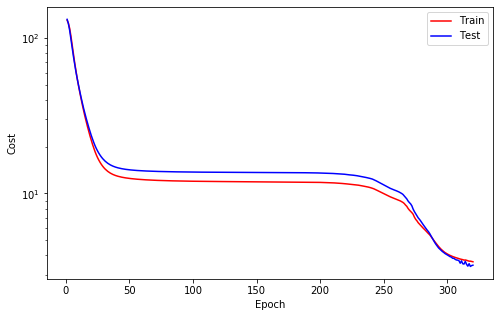

==> EarlyStop patience =  2 | Best test_cost: 3.3860




Epoch   321
Train_cost  = 3.6412 | Test_cost  = 3.2996 | 




Epoch   322
Train_cost  = 3.6877 | Test_cost  = 3.5033 | 
==> EarlyStop patience =  1 | Best test_cost: 3.2996




Epoch   323
Train_cost  = 3.7687 | Test_cost  = 3.4918 | 
==> EarlyStop patience =  2 | Best test_cost: 3.2996




Epoch   324
Train_cost  = 3.6480 | Test_cost  = 3.2294 | 




Epoch   325
Train_cost  = 3.6941 | Test_cost  = 3.2223 | 




Epoch   326
Train_cost  = 3.6027 | Test_cost  = 3.2392 | 
==> EarlyStop patience =  1 | Best test_cost: 3.2223




Epoch   327
Train_cost  = 3.6148 | Test_cost  = 3.2910 | 
==> EarlyStop patience =  2 | Best test_cost: 3.2223




Epoch   328
Train_cost  = 3.5794 | Test_cost  = 3.1770 | 




Epoch   329
Train_cost  = 3.5615 | Test_cost  = 3.1850 | 
==> EarlyStop patience =  1 | Best test_cost: 3.1770




Epoch   330
Train_cost  = 3.5428 | Test_cost  = 3.2278 | 
==> EarlyStop patience =  2 | Best test_cost: 3.1770




Epoch   331
Train_cost  = 3.5208 | Test_cost  = 3.3002 | 
==> EarlyStop patience =  3 | Best test_cost: 3.1770




Epoch   332
Train_cost  = 3.5088 | Test_cost  = 3.2690 | 
==> EarlyStop patience =  4 | Best test_cost: 3.1770




Epoch   333
Train_cost  = 3.4934 | Test_cost  = 3.2632 | 
==> EarlyStop patience =  5 | Best test_cost: 3.1770
==> Execute Early Stopping at epoch: 333 | Best test_cost: 3.1770
==> Best model is saved at model/lstm


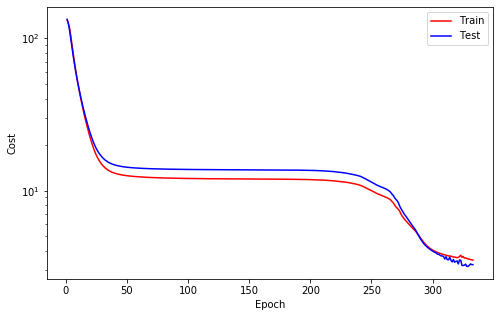

In [14]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Forecast

In [15]:
from luwiji.rnn import illustration

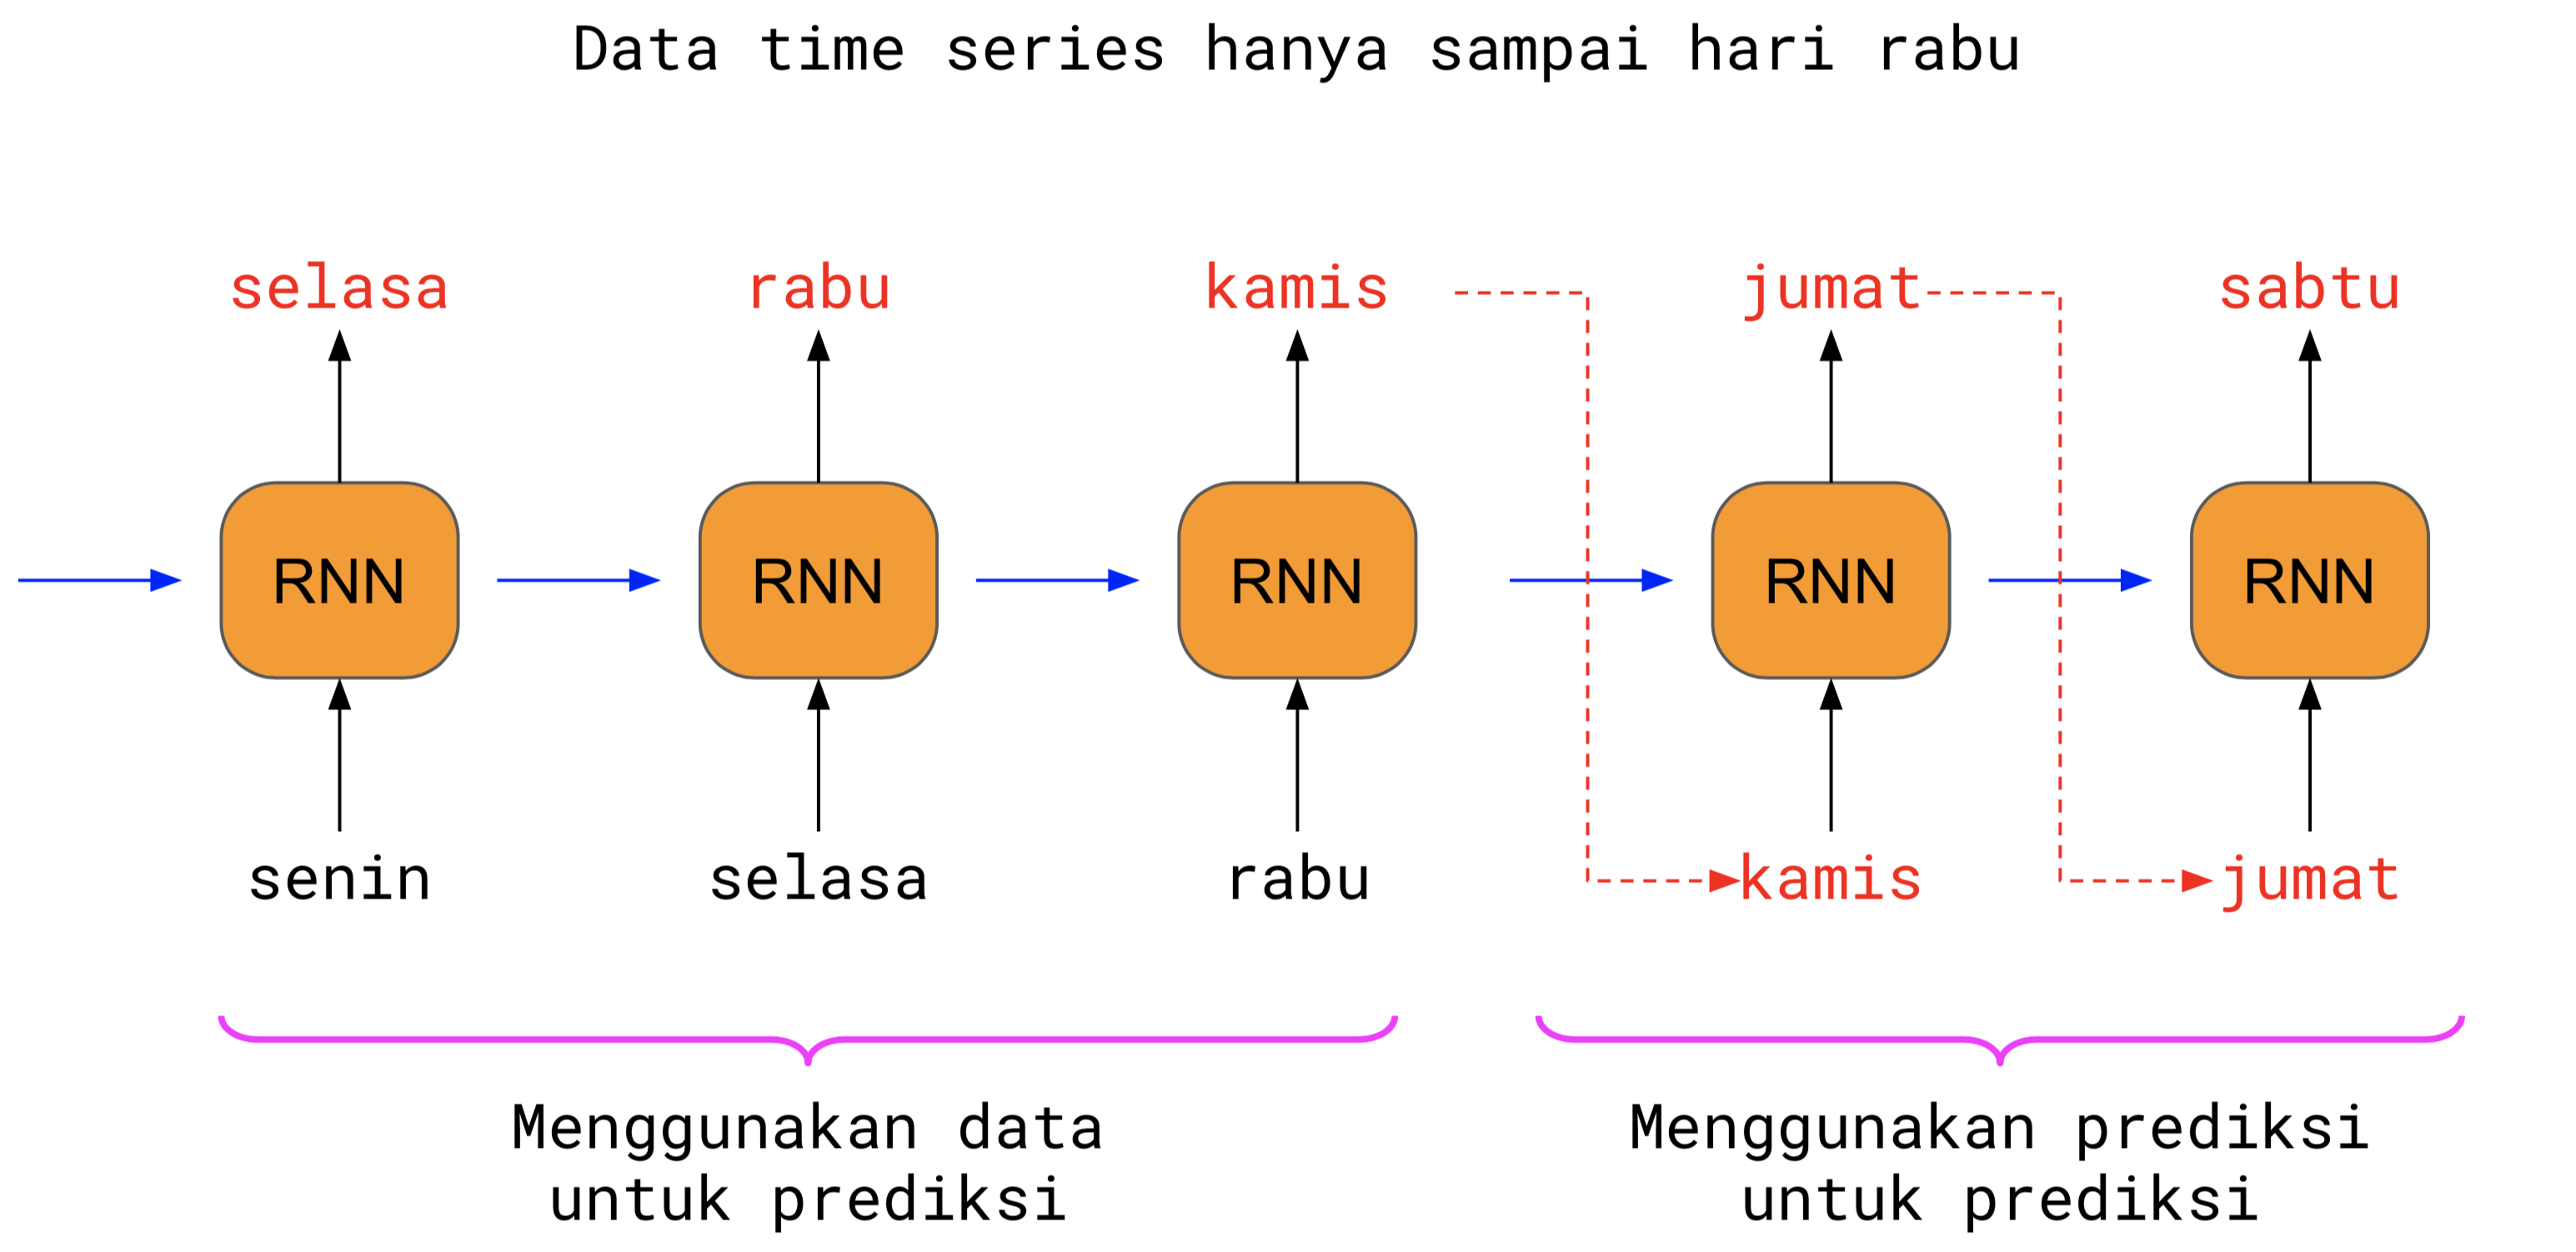

In [16]:
illustration.forecast

In [17]:
from utils import data4pred, pred4pred

In [18]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (417, 1, 1)
Note: last 0 data excluded

(N, S, F): (104, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

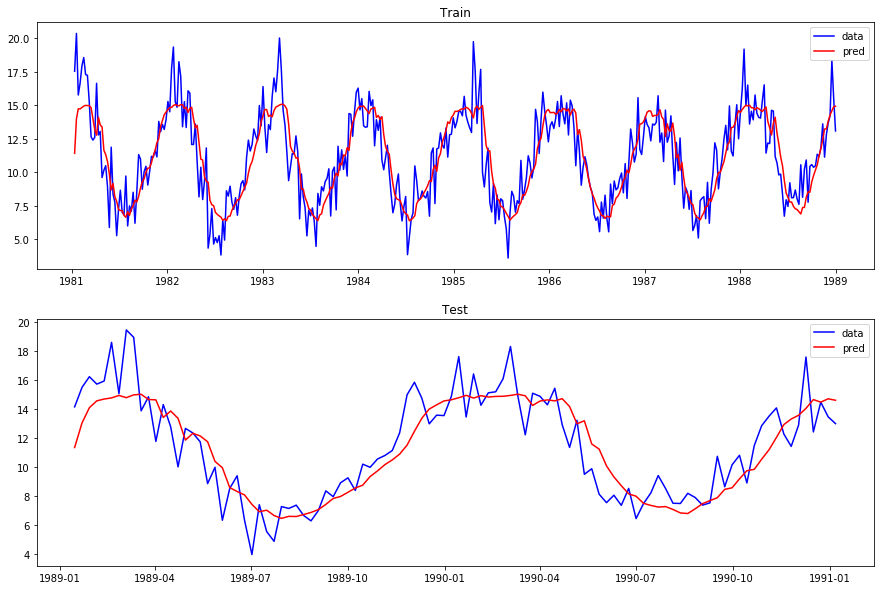

In [19]:
plt.figure(figsize=(15, 10))
    
plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

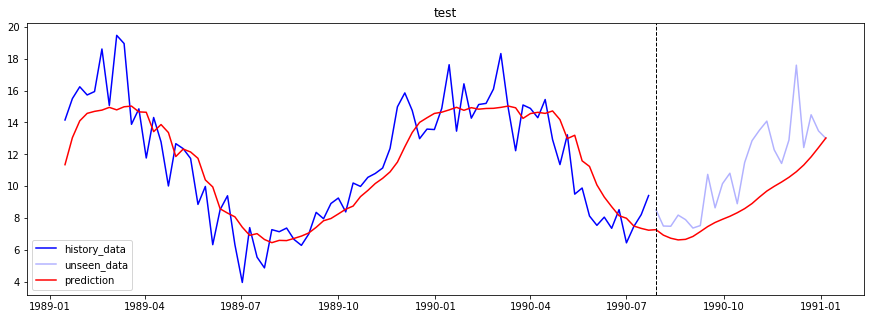

In [27]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=80, n_forecast=110)
plt.title("test");